# Taylor rule - Monetary Policy

#### Imports and set magics:

In [12]:
import numpy as np
from scipy import optimize
from scipy.optimize import minimize, show_options
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd
# Import itertools for generating parameter combinations
from itertools import product
import statsmodels.api as sm

#pip install matplotlib-venn

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Taylor rule model description

The Taylor rule is not to be confused with Taylors law or Taylors Theorem. It is a monetary targeting rule by American economist John B. Taylor for central banks to use to stabilize ecnomic activity. It does so by appropriately setting short-term interest rates. The rule does so by using the gap between the targeted inflation rate and the actual inflation rate. It also uses the output gap between the actual and natural output level. The Taylor rule for monetary policy is defined as:

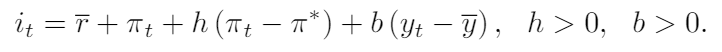

Here the components are as follows:
- $\pi^*$ is the central banks inflation target.
- $\bar r$ denotes the natural real interest rate.
- $(y_t - \bar y)$ is the output gap.
- $i_t$ is the nominal interest rate.
- $\pi_t$ is the rate of inflation.
- Empirical evidence shows that if the parameters $h$ and $b$ are both set equal to $0,5$, the taylor rule provides a good description of actual US monetary policy in recent decades.

Since Denmark follows a fixed exchange rate policy towards the euro, the Danish central bank is unable to change its interest rate in response to changes in domestic inflation or output gap. That is Danmarks Nationalbank does not follow a Taylor rule, but nevertheless it can be interesting to compare the actual interest rate set by Nationalbanken to a "hypothetical" Taylor rule for the Danish economy. For example this may give an indication of whether the current level of the interest rate is very stimulative or the opposite, which may be helpful in decisions about fiscal policy. In (Ravn, Søren Hove, 2012: Rules versus Dictation: A Taylor Rule for Denmark, Nationaløkonomisk Tidsskrift 150(1), p. 22-42.) they find that during the peiod 1994-2009 the actual interest rate was not "too" different from such a hypothetical interest rate.

#### Setting up an API to collect data

In [13]:
# installing API reader, that will allow to load data from DST.
%pip install git+https://github.com/alemartinello/dstapi
%pip install pandas-datareader

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

  Cloning https://github.com/alemartinello/dstapi to c:\users\thomas\appdata\local\temp\pip-req-build-rjd2e3pv
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi 'C:\Users\Thomas\AppData\Local\Temp\pip-req-build-rjd2e3pv'


Note: you may need to restart the kernel to use updated packages.


In [15]:
kvartal_bnp = DstApi('NKN1')
tabsum2 = kvartal_bnp.tablesummary(language = 'en')
display(tabsum2)
for variable in tabsum2['variable name']:
    print(variable+':')
    display(kvartal_bnp.variable_levels(variable, language='en'))

Table NKN1: Demand and supply by transaction, price unit, seasonal adjustment and time
Last update: 2024-03-27T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,31,B1GQK,B.1*g Gross domestic product,EMPM_DC,"Total employment (1,000 persons)",False
1,PRISENHED,6,V_M,"Current prices, (bill. DKK.)",LKV_C,"Pr. capita, 2010-prices, chained values, (1000...",False
2,SÆSON,2,N,Non-seasonally adjusted,Y,Seasonally adjusted,False
3,Tid,136,1990K1,1990Q1,2023K4,2023Q4,True


TRANSAKT:


,id,text
0,B1GQK,B.1*g Gross domestic product
1,P7K,P.7 Imports of goods and services
2,P71K,P.71 Import of goods
3,P72K,P.72 Import of services
4,TFSPR,Supply
5,P6D,P.6 Exports of goods and services
6,P61D,P.61 Export of goods
7,P62D,P.62 Export of services
8,P31S1MD,P.31 Private consumption
9,P31S14D,P.31 Household consumption expenditure


PRISENHED:


,id,text
0,V_M,"Current prices, (bill. DKK.)"
1,L_V,Period-to-period real growth (per cent)
2,V_C,"Pr. capita. Current prices, (1000 DKK.)"
3,LKV_M,"2010-prices, chained values, (bill. DKK.)"
4,L_VB,"Contribution to GDP growth, (percentage point)"
5,LKV_C,"Pr. capita, 2010-prices, chained values, (1000..."


SÆSON:


,id,text
0,N,Non-seasonally adjusted
1,Y,Seasonally adjusted


Tid:


,id,text
0,1990K1,1990Q1
1,1990K2,1990Q2
2,1990K3,1990Q3
3,1990K4,1990Q4
4,1991K1,1991Q1
...,...,...
131,2022K4,2022Q4
132,2023K1,2023Q1
133,2023K2,2023Q2
134,2023K3,2023Q3


In [16]:
#Quarterly BNP, seasonally adjusted
print(modelproject.quarterly_BNP())

          TID INDHOLD
7299   1990Q1      ..
40777  1990Q2      ..
29914  1990Q3      ..
15804  1990Q4      ..
12552  1991Q1   326.6
...       ...     ...
8529   2022Q4   570.1
24692  2023Q1   577.5
11246  2023Q2   572.9
23305  2023Q3   574.9
46360  2023Q4   589.9

[136 rows x 2 columns]


#### Defining the Taylor rule function and parameters

In [ ]:
# Example parameter initialization
r_bar = 0.01  # Long-term equilibrium real interest rate
pi_t = np.array([0.02, 0.025, 0.03])  # Current inflation rates
pi_star = 0.02  # Target inflation rate set to 2 percent as it is ECB target.
y_t = np.array([100, 105, 110])  # Current output levels
y_bar = 100  # Potential output level
h = 0.5  # Weight for the inflation gap
b = 0.5  # Weight for the output gap

# Define the Taylor rule function based on the given formula
def taylor_rule(r_bar, pi_t, pi_star, y_t, y_bar, h, b):
    """
    Calculate the target nominal interest rate using the Taylor rule formula.

    Parameters:
    - r_bar (float): Long-term equilibrium real interest rate
    - pi_t (float or np.array): Current inflation rate
    - pi_star (float): Target inflation rate
    - y_t (float or np.array): Current output
    - y_bar (float): Potential output
    - h (float): Weight for the inflation gap
    - b (float): Weight for the output gap

    Returns:
    - np.array: Target nominal interest rates
    """
    inflation_gap = pi_t - pi_star
    output_gap = y_t - y_bar
    it = r_bar + pi_t + h * inflation_gap + b * output_gap
    return it

# Calculate the target nominal interest rates using the defined function
target_interest_rates = taylor_rule(r_bar, pi_t, pi_star, y_t, y_bar, h, b)

# Print the calculated rates
print("Calculated Taylor Rule Nominal Interest Rates:", target_interest_rates)


#### HP-Filter

In [ ]:
# Store the cycle and the trend
cycle, trend = sm.tsa.filters.hpfilter(log_real_gdp, 1600)

fig, ax = plt.subplots(1, 1,sharex=True,figsize=(15, 8))

df_trend = pd.DataFrame(index = real_gdp.index, data = trend)
df_log_real_gdp = pd.DataFrame(index = real_gdp.index, data = log_real_gdp)

ax.set_title('Log Real GDP vs Statsmodels Trend',size = 20);

ax.plot(df_trend);
ax.plot(df_log_real_gdp);
ax.legend(['Trend of real US GDP','Real US GDP']);

##### Vi skal have taget logaritmen af bnp og så skal vi se om HP filteret kører
##### TJEKKE AT PARAMETRE OG FUNKTION ER DEFINERET RIGTIGT
##### Indhent mere data så vi har alt til analysen

# Conclusion

Add concise conclusion. 